In [1]:
#lib imports
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#local imports
from utils import *
from plotting import *
from model_creator import *
from image_processing import *

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Python version: ', os.sys.version)

TensorFlow version:  2.18.0
Keras version:  3.6.0
Python version:  3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]


In [2]:
local_dir = './'
original_data_dir = os.path.join(local_dir, 'src_data_mediapipe')
# src_data contains the original data from the Kaggle dataset together with the augmented data from 'resized_images'
dataset_dir = os.path.join(local_dir, 'dataset_mediapipe')
models_dir = os.path.join(local_dir, 'models_mediapipe')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

if not os.path.exists(original_data_dir):
    raise FileNotFoundError('Original data directory not found')

classes = ['rock', 'paper', 'scissors']
splits = ['train', 'val', 'test']

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    split_dataset(classes, original_data_dir, dataset_dir, split_proportions=[0.7, 0.15, 0.15])
    convert_images_to_grayscale(dataset_dir, splits, classes)
    

for path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f'{path} not found')
    
    print(path)
    for class_name in classes:
        print(f'    - {class_name}: {len(os.listdir(os.path.join(path, class_name)))} images')
  

Converting images to grayscale...
Converted 0 images to grayscale, skipped 5151 images.
./dataset_mediapipe\train
    - rock: 1168 images
    - paper: 1283 images
    - scissors: 1154 images
./dataset_mediapipe\val
    - rock: 250 images
    - paper: 275 images
    - scissors: 247 images
./dataset_mediapipe\test
    - rock: 251 images
    - paper: 275 images
    - scissors: 248 images


In [3]:
check_for_duplicates_in_dataset('./dataset_grayscale')

No duplicates found in dataset
5728 files found in dataset


Found 3605 images belonging to 3 classes.
Found 772 images belonging to 3 classes.
Found 774 images belonging to 3 classes.


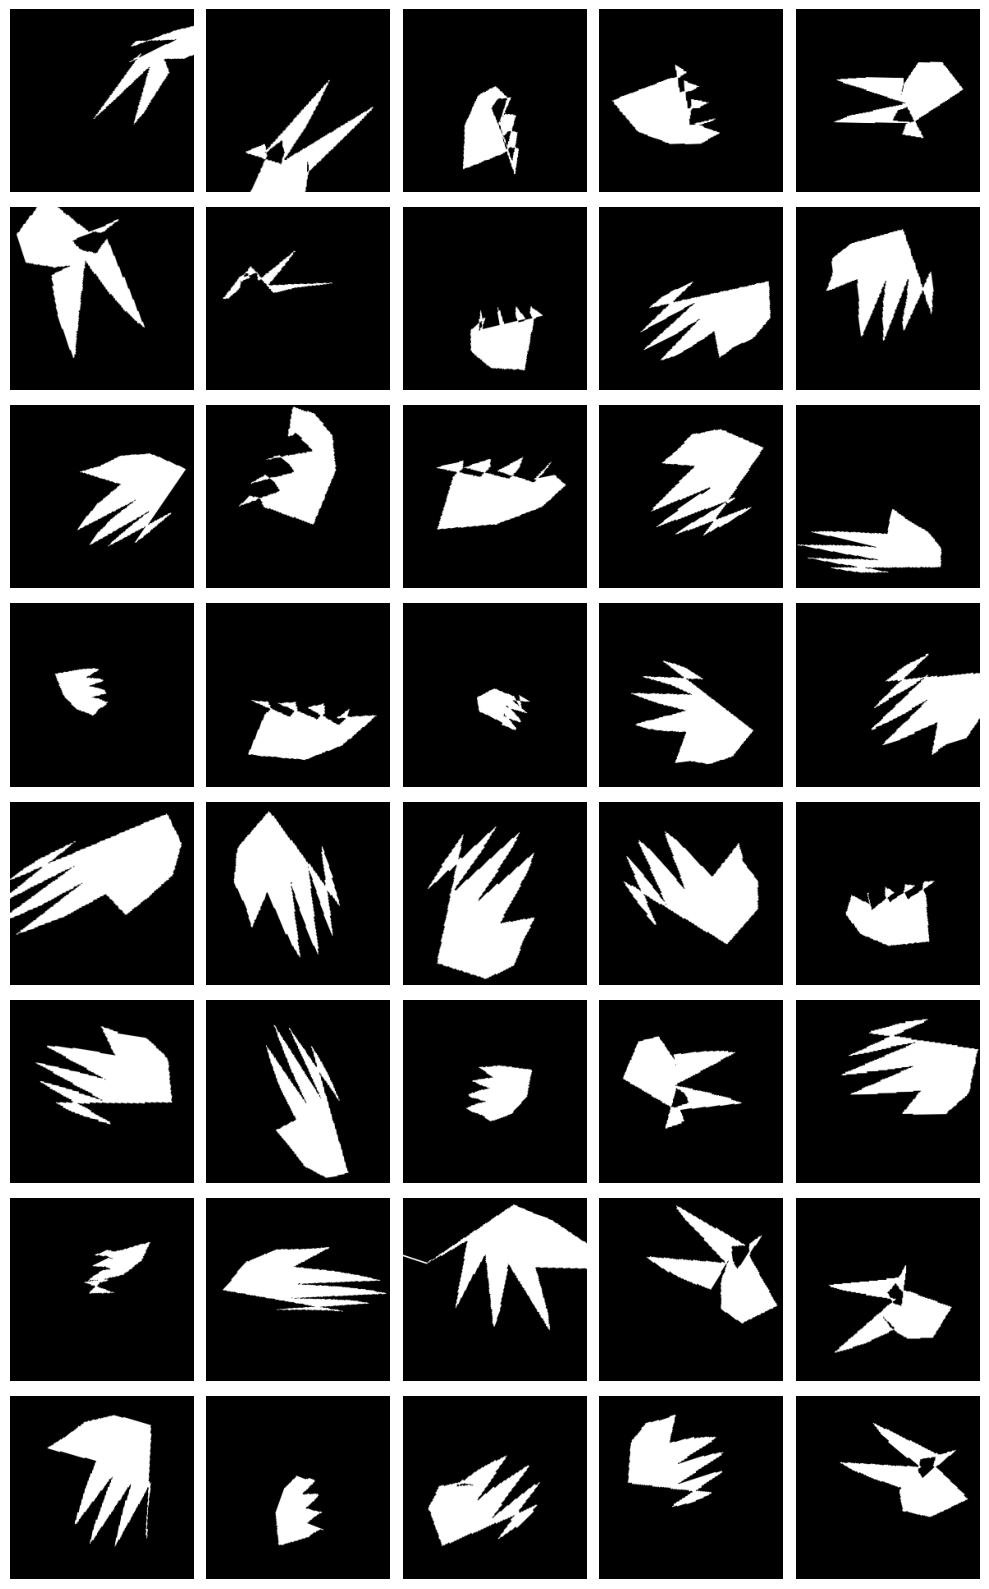

In [4]:
# Image target size
img_rows, img_cols = 224, 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    vertical_flip=True,
    )


test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

plot_grid_from_generator(train_generator, 8, 5, cmap='gray')

In [5]:
EPOCHS = 100
MODEL_NAME = 'cnn_mediapipe_medium'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

csvlogger_callback = tf.keras.callbacks.CSVLogger(
    filename=os.path.join(models_dir, f'{MODEL_NAME}_ckp_history.csv'),     
    separator=',',                      
    append=True                           
)

# Channels: 1 for grayscale (3 for RGB), arg 'input_shape' in the model
hist_dict = compile_and_train_model(
    create_model_func=build_cnn_medium,
    create_model_args={'input_shape' : (224, 224, 1), 'num_classes' :3},
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['acc'], 
    train_generator=train_generator,
    val_generator=val_generator,
    epochs=EPOCHS,
    models_dir=models_dir,
    model_name=MODEL_NAME,
    callbacks=[checkpoint_callback, csvlogger_callback]
)

c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - acc: 0.5713 - loss: 1.0853 - val_acc: 0.3238 - val_loss: 4.0667
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - acc: 0.7924 - loss: 0.5537 - val_acc: 0.3238 - val_loss: 6.8160
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - acc: 0.8761 - loss: 0.3718 - val_acc: 0.3238 - val_loss: 6.9170
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 113s 996ms/step - acc: 0.9088 - loss: 0.2871 - val_acc: 0.3238 - val_loss: 5.4866
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - acc: 0.9303 - loss: 0.2334 - val_acc: 0.6425 - val_loss: 0.9116
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 108s 956ms/step - acc: 0.9370 - loss: 0.2119 - val_acc: 0.9197 - val_loss: 0.2272
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - acc: 0.9315 - loss: 0.2172 - val_acc: 0.8601 - val_loss: 0.4447
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - acc: 0.9431 - loss: 0.2032 - val_acc: 0.7085 - val_loss: 1.0896
Epoch 9/100
113/113 ━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
plot_accuracy_and_loss(hist_dict)